### XGBoost Models

#### Dataset Loading and Import Statements

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.utils import resample
from xgboost import XGBRegressor

df_cleaned = pd.read_csv("./df_cleaned_new2.csv")
tgt='SalePrice'
X=df_cleaned.drop(columns=[tgt])
y=df_cleaned[tgt]
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=42)

#### Feature Importance Analysis - Selection (Confidence Intervals for Feature Importance)

In [11]:
# Get feature importances
n_bootstraps = 1000 #number of iterations 
n_estimators=100

feature_importances=pd.DataFrame(index=range(n_bootstraps), columns=Xtrain.columns)

#bootstrap to determine feature importance by fitting XGBoost model at each iter
for i in range (n_bootstraps):
    X_resampled, y_resampled = resample(X, y, random_state=i)

    #fitting model
    xgb=XGBRegressor(n_estimators=n_estimators, random_state=i)
    xgb.fit(X_resampled, y_resampled)

    feature_importances.iloc[i]=pd.Series(xgb.feature_importances_, index=X.columns).reindex(Xtrain.columns, fill_value=0)
    feature_importances=feature_importances.fillna(0)

#importance quantities calculated here from CIs
importance_means = feature_importances.mean()
importance_stds = feature_importances.std()
importance_ci_low = feature_importances.quantile(0.025)
importance_ci_high = feature_importances.quantile(0.975)

# Summary table of all features and their associated values
importance_summary = pd.DataFrame({
    'Mean Importance': importance_means,
    'Standard Deviation': importance_stds,
    '95% CI Lower': importance_ci_low,
    '95% CI Upper': importance_ci_high
})
importance_summary = importance_summary.sort_values(by='Mean Importance', ascending=False)

/var/folders/ls/gtsmsnhn6353gdspcyv20jym0000gn/T/ipykernel_4189/422750308.py:16: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  feature_importances=feature_importances.fillna(0)


#### Optimizizing Threshold for Feature Importance (and Selection)

In [12]:
#function to test different threshold value - returns the MSE with the associated thresh
def evaluate_threshold(threshold):
    features_to_keep = importance_summary[
        (importance_summary['Mean Importance'] > threshold) &
        (importance_summary['95% CI Lower'] > 0)
        ].index
    Xtrain_reduced = Xtrain[features_to_keep]
    reduced_base_rf = RandomForestRegressor(n_estimators=100, random_state=42)
    cv_reduced = cross_val_score(reduced_base_rf, Xtrain_reduced, ytrain, cv=5, scoring='neg_mean_squared_error')
    return -cv_reduced.mean()  

# threshold consideration set
thresholds = np.linspace(0.0005, 0.005, 10)
results = {thresh: evaluate_threshold(thresh) for thresh in thresholds}
best_thresh = min(results, key=results.get)
print("Optimal Threshold: ", best_thresh, "CV MSE: ,", results[best_thresh])

Optimal Threshold:  0.0045000000000000005 CV MSE: , 489778379.3737153


#### Feature Selection (based on Feature Importance):

Features to remove: ['3SsnPorch', 'BedroomAbvGr', 'BldgType_1Fam', 'BldgType_2fmCon', 'BldgType_Duplex', 'BldgType_Twnhs', 'BldgType_TwnhsE', 'BsmtCond_Fa', 'BsmtCond_Gd', 'BsmtCond_None', 'BsmtCond_TA', 'BsmtExposure_Av', 'BsmtExposure_Gd', 'BsmtExposure_Mn', 'BsmtExposure_No', 'BsmtExposure_None', 'BsmtFinSF2', 'BsmtFinType1_ALQ', 'BsmtFinType1_BLQ', 'BsmtFinType1_GLQ', 'BsmtFinType1_LwQ', 'BsmtFinType1_None', 'BsmtFinType1_Rec', 'BsmtFinType1_Unf', 'BsmtFinType2_ALQ', 'BsmtFinType2_BLQ', 'BsmtFinType2_LwQ', 'BsmtFinType2_None', 'BsmtFinType2_Rec', 'BsmtFinType2_Unf', 'BsmtHalfBath', 'BsmtQual_Ex', 'BsmtQual_Fa', 'BsmtQual_Gd', 'BsmtQual_None', 'BsmtQual_TA', 'BsmtUnfSF', 'CentralAir_N', 'CentralAir_Y', 'Condition1_Artery', 'Condition1_Feedr', 'Condition1_Norm', 'Condition1_PosN', 'Condition1_RRAn', 'Electrical_FuseA', 'Electrical_FuseF', 'Electrical_SBrkr', 'EnclosedPorch', 'ExterCond_Fa', 'ExterCond_Gd', 'ExterCond_TA', 'ExterQual_Ex', 'ExterQual_Gd', 'ExterQual_TA', 'Exterior1st_A

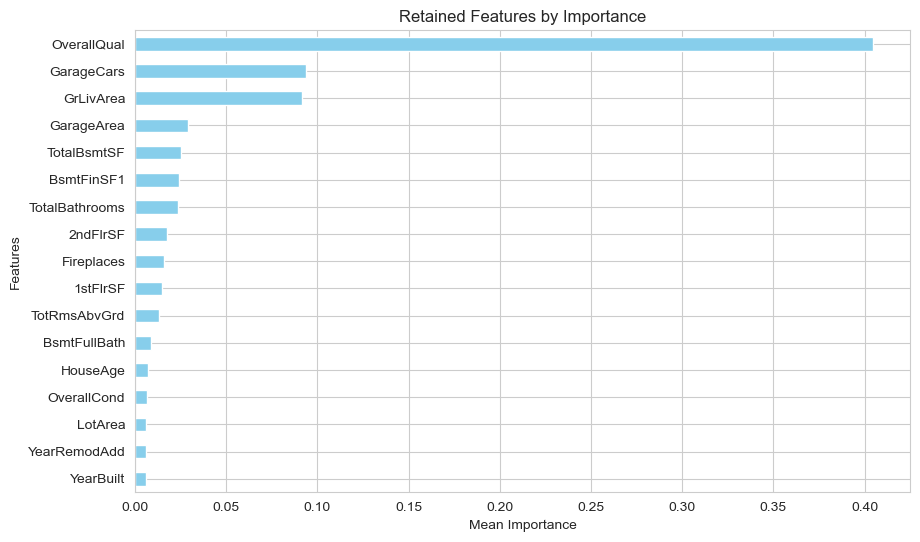

Original CV MSE: -550714546.2943966
Reduced CV MSE: -498231263.53823835


In [13]:
#threshold for mean importance value (based on prev function)
importance_thresh = best_thresh 

# features to keep based on quantile and CI bounds 
features_to_keep = importance_summary[
    (importance_summary['Mean Importance'] > importance_thresh) &
    (importance_summary['95% CI Lower'] > 0)
    ].index

features_to_remove = importance_summary.index.difference(features_to_keep)

print("Features to remove:", features_to_remove.tolist())
print("Number of features to remove:", len(features_to_remove))
print("Number of features to keep:", len(features_to_keep))

#visualizing the retained (kept) features
retained_feat = importance_summary.loc[features_to_keep]
plt.figure(figsize=(10, 6))
retained_feat['Mean Importance'].sort_values().plot(kind='barh', color='skyblue')
plt.title('Retained Features by Importance')
plt.xlabel('Mean Importance')
plt.ylabel('Features')
plt.show()

Xtrain_reduced = Xtrain[features_to_keep]
Xtest_reduced = Xtest[features_to_keep]

# baseline model on reduced dataset
baseline_xgb = XGBRegressor(n_estimators=100, random_state=42)
baseline_xgb.fit(Xtrain_reduced, ytrain)

# comparing baseline performance on original and reduced dataset
cv_original = cross_val_score(
    XGBRegressor(n_estimators=100, random_state=42),
    Xtrain, ytrain, cv=5, scoring='neg_mean_squared_error', n_jobs=-1
)
cv_reduced = cross_val_score(
    XGBRegressor(n_estimators=100, random_state=42),
    Xtrain_reduced, ytrain, cv=5, scoring='neg_mean_squared_error', n_jobs=-1
)

print("Original CV MSE:", cv_original.mean())
print("Reduced CV MSE:", cv_reduced.mean())

#### Hypertuning Model Parameters with Regularization (RandomizedSearchCV):

In [14]:
# parameter grid for GridSearch
param_grid = {
    'n_estimators': [500, 1000],  # of boosting rounds
    # range covers moderate and higher values - to balance performance and computation
    'max_depth': [3, 4, 5],  # Maximum depth of each tree
    # wanted shallower trees to prevent overfitting and ensure generalization ability
    'learning_rate': [0.01, 0.02],  # Shrinkage parameter
    # controls the individual contrib. of trees to the overall model (slower, stable learning)
}

# grid search set up
grid_search = GridSearchCV(
    estimator=XGBRegressor(random_state=42),
    param_grid=param_grid,              #param grid above
    scoring='neg_mean_squared_error',  # MSE = scoring metrics
    cv=5,                               # 5-fold cross-validation (10-fold more robust but more computationally intensive)
    verbose=1,
    n_jobs=-1,                   # faster runtime - w/ parallel computation
)

# fit XGBModel with best parameters
grid_search.fit(Xtrain_reduced, ytrain)

# best XGB parameters and estimator
best_xgb_1 = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)
print("Best CV MAE Score:", -grid_search.best_score_)

#testing and training predictions
y_train_pred_best_1 = best_xgb_1.predict(Xtrain_reduced)
y_test_pred_best_1 = best_xgb_1.predict(Xtest_reduced)

#model evaluation metrics
print("Best Model Training R²:", r2_score(ytrain, y_train_pred_best_1))
print("Best Model Training MAE:", mean_absolute_error(ytrain, y_train_pred_best_1))
print("Best Model Training MSE:", mean_squared_error(ytrain, y_train_pred_best_1))

print("Best Model Testing R²:", r2_score(ytest, y_test_pred_best_1))
print("Best Model Testing MAE:", mean_absolute_error(ytest, y_test_pred_best_1))
print("Best Model Testing MSE:", mean_squared_error(ytest, y_test_pred_best_1))

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Parameters: {'learning_rate': 0.02, 'max_depth': 3, 'n_estimators': 1000}
Best CV MAE Score: 370763041.0387407
Best Model Training R²: 0.9786293310655094
Best Model Training MAE: 6388.058448304521
Best Model Training MSE: 85090228.32928994
Best Model Testing R²: 0.9248088902050784
Best Model Testing MAE: 10969.764990061838
Best Model Testing MSE: 313471328.8172989


#### Second Iteration - Hypertuning Model Parameters with GridSearchCV:

In [15]:
# new parameter grid for iterative tuning
param_grid = {
    'n_estimators': [800,1000, 1200],           # num of boosting rounds (>1200 = risk of overfitting)
    'max_depth': [2,3,4],                       # shallow trees reduce overfitting
    'learning_rate': [0.015, 0.02],     # lower values for slower, steady learning process to prevent overfitting
    'subsample': [0.65, 0.7],         # fract of train data used for each boosting round (introduces randomness and reduces overfitting)
    'colsample_bytree': [0.65, 0.7],  # fract of features considered for each tree 
    #range encourages feature diversity and reduce correlation between trees
    'reg_alpha': [0.5, 1, 1.5],   # adding L1 term for regularization (penalization)
    'reg_lambda': [0.5, 1, 1.5],  # adding L2 regularization term (penalization of large weights)
}

# Set up the RandomizedSearchCV
grid_search2 = GridSearchCV(
    estimator=XGBRegressor(random_state=42),
    param_grid=param_grid,              # Number of parameter settings to sample
    scoring='neg_mean_squared_error', # MSE = scorer
    cv=10,                    # 10-fold cross-validation
    verbose=1,
    n_jobs=-1,               # Use all available cores
)

# fitting second iteration XGB Model
grid_search2.fit(Xtrain_reduced, ytrain)

best_xgb_2 = grid_search2.best_estimator_
print("Best Parameters:", grid_search2.best_params_)
print("Best CV MSE Score:", -grid_search2.best_score_)

# training and testing parameters for second iteration best XGB model
y_train_pred_best_2 = best_xgb_2.predict(Xtrain_reduced)
y_test_pred_best_2 = best_xgb_2.predict(Xtest_reduced)

# model evaluation metrics
print("Best Model Training R²:", r2_score(ytrain, y_train_pred_best_2))
print("Best Model Training MAE:", mean_absolute_error(ytrain, y_train_pred_best_2))
print("Best Model Training MSE:", mean_squared_error(ytrain, y_train_pred_best_2))
print("\n")
print("Best Model Testing R²:", r2_score(ytest, y_test_pred_best_2))
print("Best Model Testing MAE:", mean_absolute_error(ytest, y_test_pred_best_2))
print("Best Model Testing MSE:", mean_squared_error(ytest, y_test_pred_best_2))

Fitting 10 folds for each of 648 candidates, totalling 6480 fits
Best Parameters: {'colsample_bytree': 0.65, 'learning_rate': 0.02, 'max_depth': 3, 'n_estimators': 1200, 'reg_alpha': 0.5, 'reg_lambda': 1, 'subsample': 0.65}
Best CV MSE Score: 333458145.0547773
Best Model Training R²: 0.9829918766777079
Best Model Training MAE: 5770.66267037899
Best Model Training MSE: 67720158.94228014


Best Model Testing R²: 0.934017536200546
Best Model Testing MAE: 10292.232898078622
Best Model Testing MSE: 275080533.6198287


#### Model Evaluation Metrics Table (Baseline, 1st and 2nd Iteration XGBoost Models)

In [16]:
# Baseline XGB
baseline_train_r2 = r2_score(ytrain, baseline_xgb.predict(Xtrain_reduced))
baseline_test_r2 = r2_score(ytest, baseline_xgb.predict(Xtest_reduced))
baseline_train_mse = mean_squared_error(ytrain, baseline_xgb.predict(Xtrain_reduced))
baseline_test_mse = mean_squared_error(ytest, baseline_xgb.predict(Xtest_reduced))
baseline_train_mae = mean_absolute_error(ytrain, baseline_xgb.predict(Xtrain_reduced))
baseline_test_mae = mean_absolute_error(ytest, baseline_xgb.predict(Xtest_reduced))
baseline_cv_mse = cross_val_score(
    XGBRegressor(n_estimators=100, random_state=42),
    Xtrain_reduced, ytrain, cv=5, scoring='neg_mean_squared_error', n_jobs=-1
).mean()

# 1st Iteration XGB
first_iter_train_r2 = r2_score(ytrain, y_train_pred_best_1)
first_iter_test_r2 = r2_score(ytest, y_test_pred_best_1)
first_iter_train_mse = mean_squared_error(ytrain, y_train_pred_best_1)
first_iter_test_mse = mean_squared_error(ytest, y_test_pred_best_1)
first_iter_train_mae = mean_absolute_error(ytrain, y_train_pred_best_1)
first_iter_test_mae = mean_absolute_error(ytest, y_test_pred_best_1)
first_iter_cv_mse = -grid_search.best_score_

# 2nd Iteration XGB
second_iter_train_r2 = r2_score(ytrain, y_train_pred_best_2)
second_iter_test_r2 = r2_score(ytest, y_test_pred_best_2)
second_iter_train_mse = mean_squared_error(ytrain, y_train_pred_best_2)
second_iter_test_mse = mean_squared_error(ytest, y_test_pred_best_2)
second_iter_train_mae = mean_absolute_error(ytrain, y_train_pred_best_2)
second_iter_test_mae = mean_absolute_error(ytest, y_test_pred_best_2)
second_iter_cv_mse = -grid_search2.best_score_

# data frame of values
comparison_df = pd.DataFrame({
    "Model": ["Baseline XGB", "First Iteration XGB", "Second Iteration XGB"],
    "Train R²": [baseline_train_r2, first_iter_train_r2, second_iter_train_r2],
    "Test R²": [baseline_test_r2, first_iter_test_r2, second_iter_test_r2],
    "Train MSE": [baseline_train_mse, first_iter_train_mse, second_iter_train_mse],
    "Test MSE": [baseline_test_mse, first_iter_test_mse, second_iter_test_mse],
    "Train MAE": [baseline_train_mae, first_iter_train_mae, second_iter_train_mae],
    "Test MAE": [baseline_test_mae, first_iter_test_mae, second_iter_test_mae],
    "CV MSE": [baseline_cv_mse, first_iter_cv_mse, second_iter_cv_mse]
})

print(comparison_df)

                  Model  Train R²   Test R²     Train MSE      Test MSE  \
0          Baseline XGB  0.999773  0.899481  9.044134e+05  4.190640e+08   
1   First Iteration XGB  0.978629  0.924809  8.509023e+07  3.134713e+08   
2  Second Iteration XGB  0.982992  0.934018  6.772016e+07  2.750805e+08   

     Train MAE      Test MAE        CV MSE  
0   623.940132  12808.403890 -4.982313e+08  
1  6388.058448  10969.764990  3.707630e+08  
2  5770.662670  10292.232898  3.334581e+08  


#### Visualizing Performance of First and Second Iteration Models

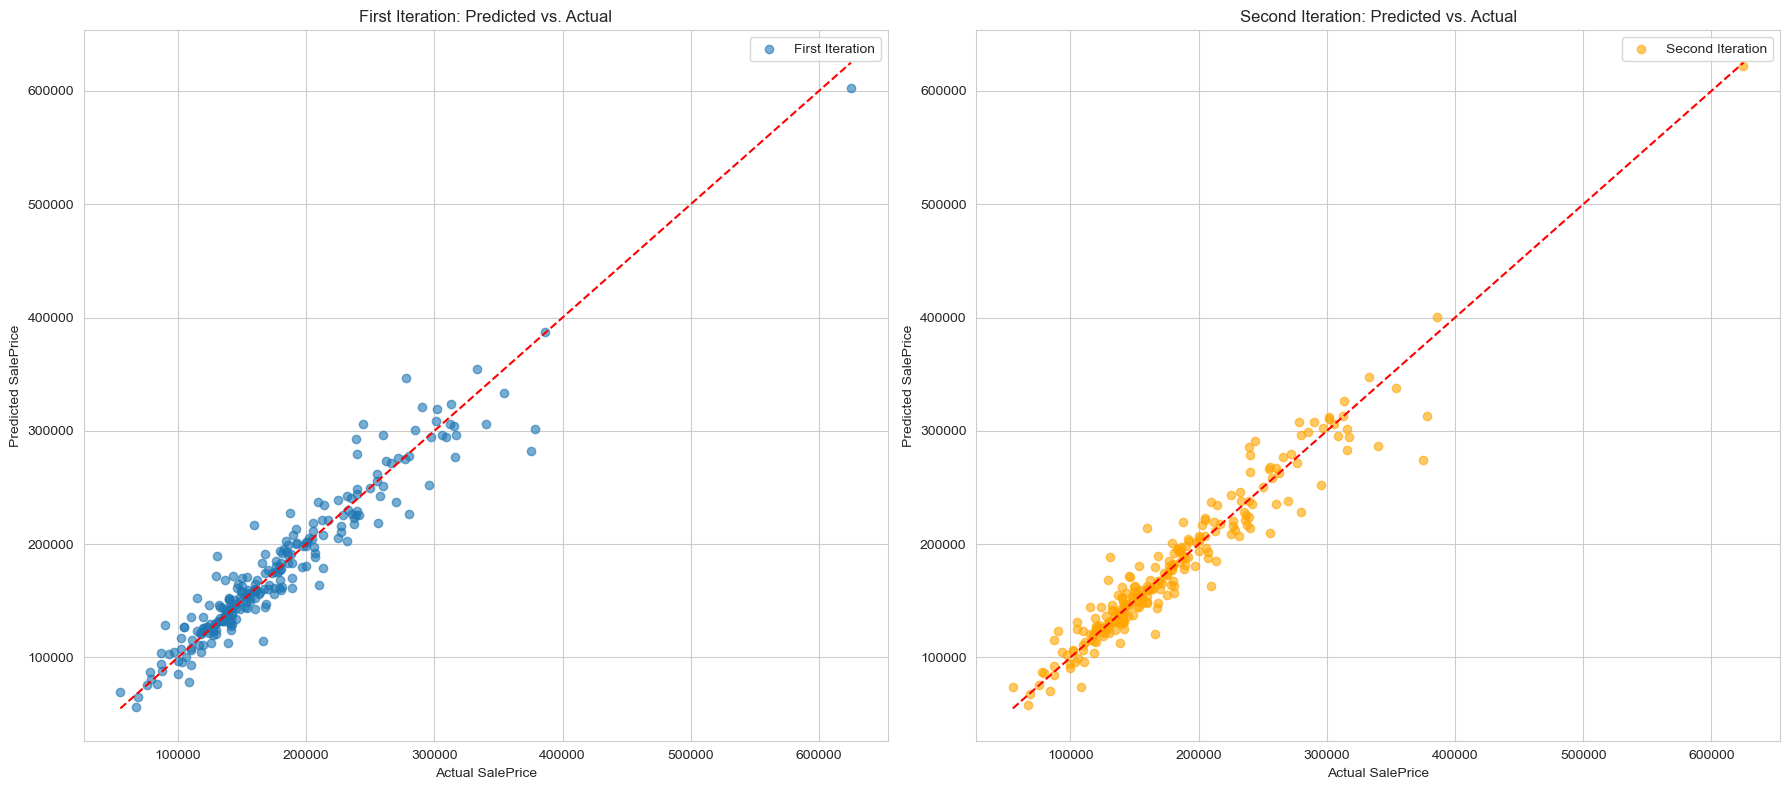

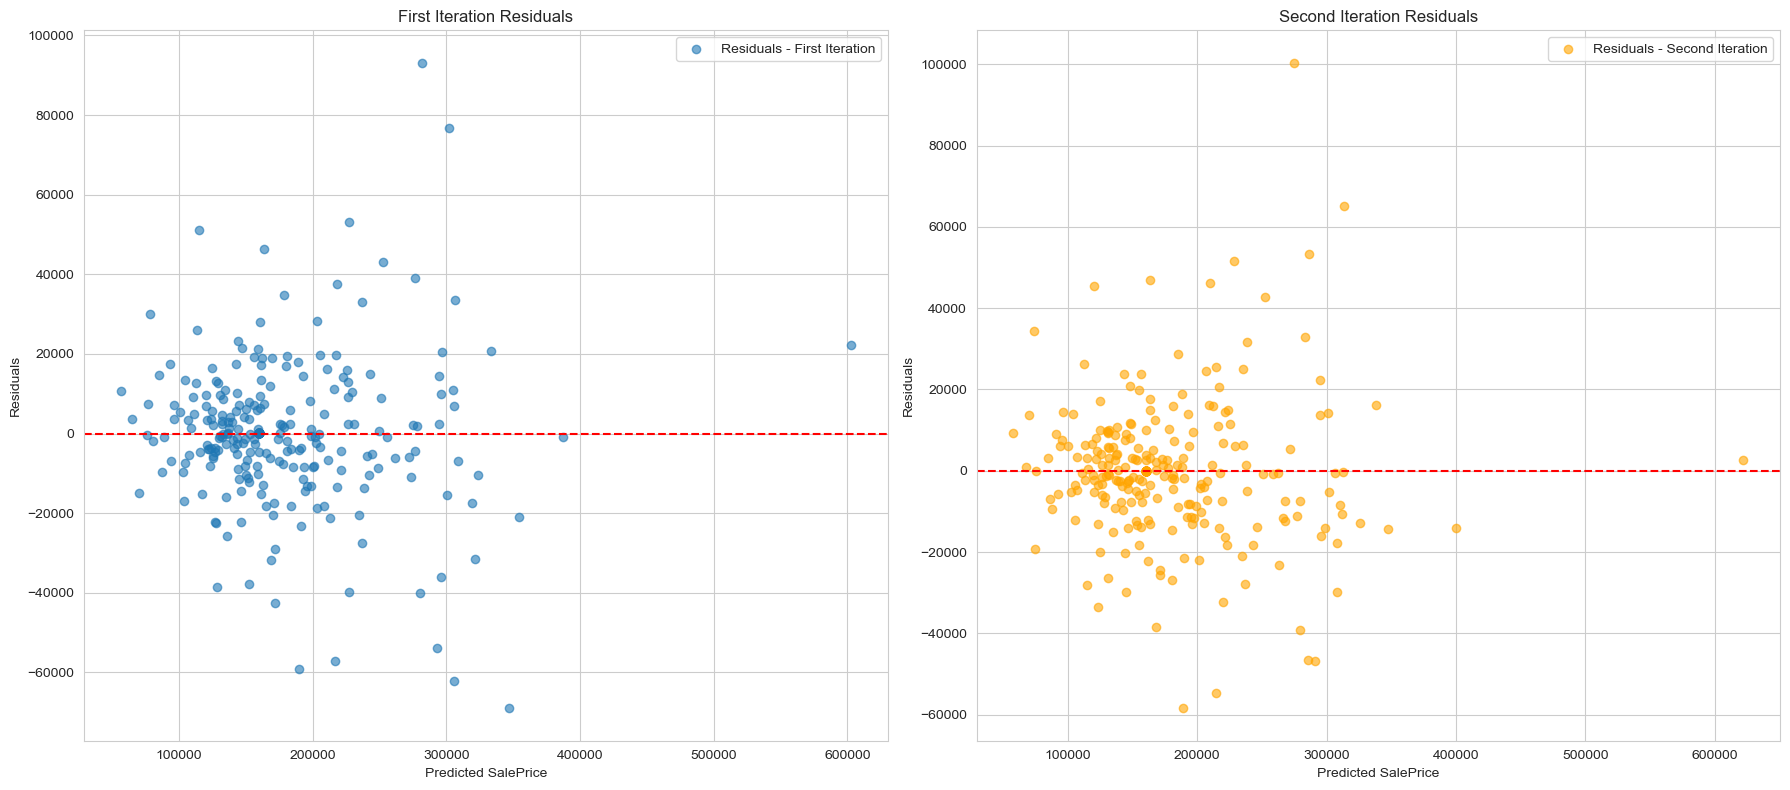

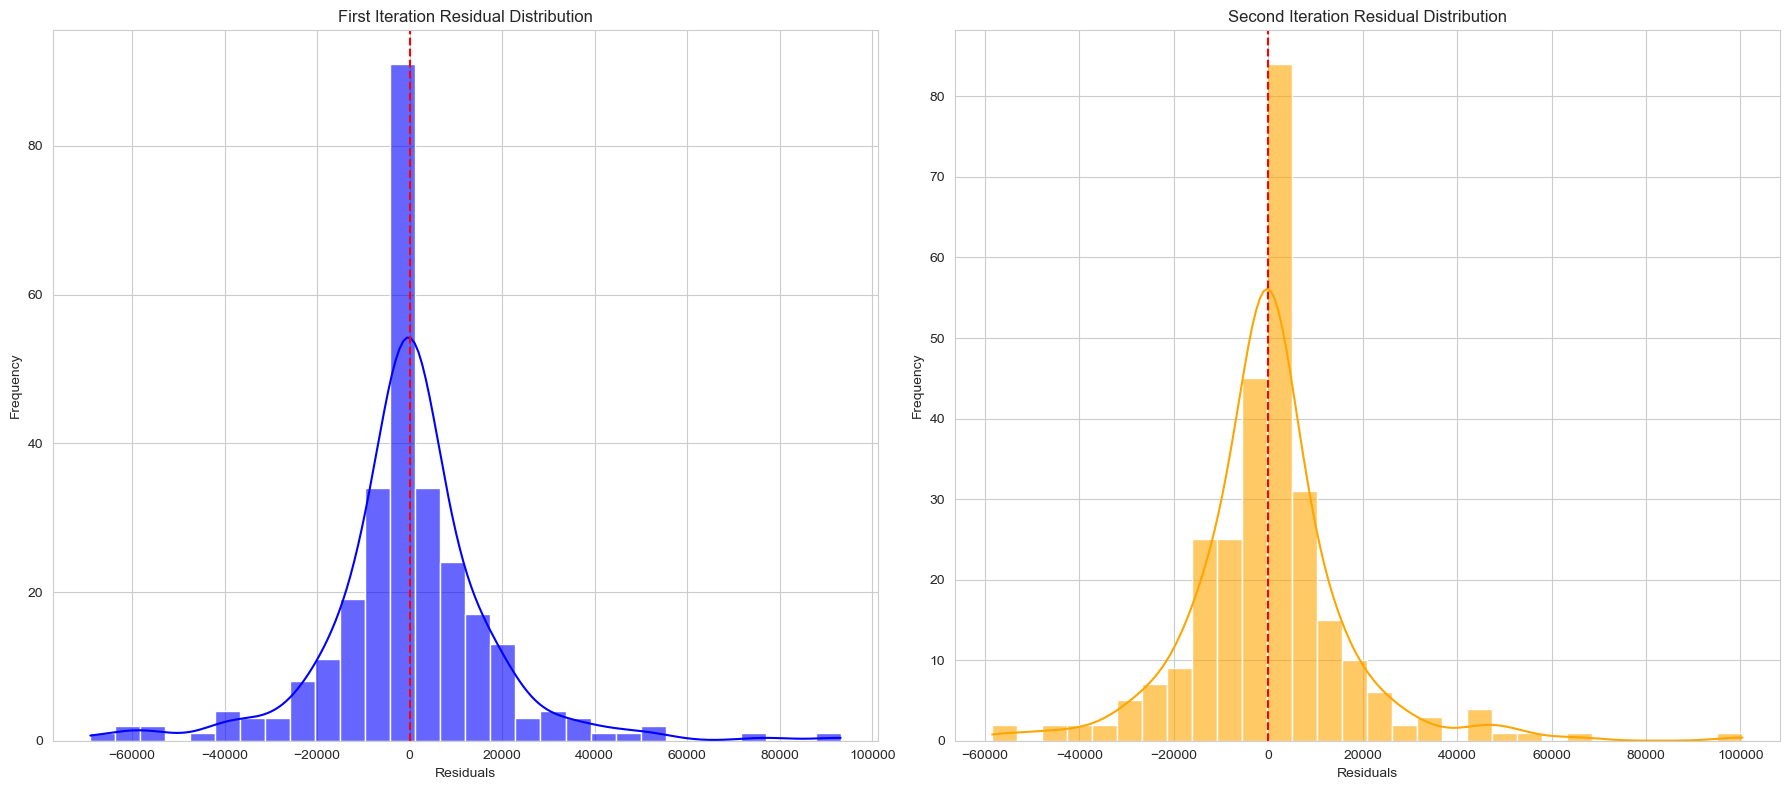

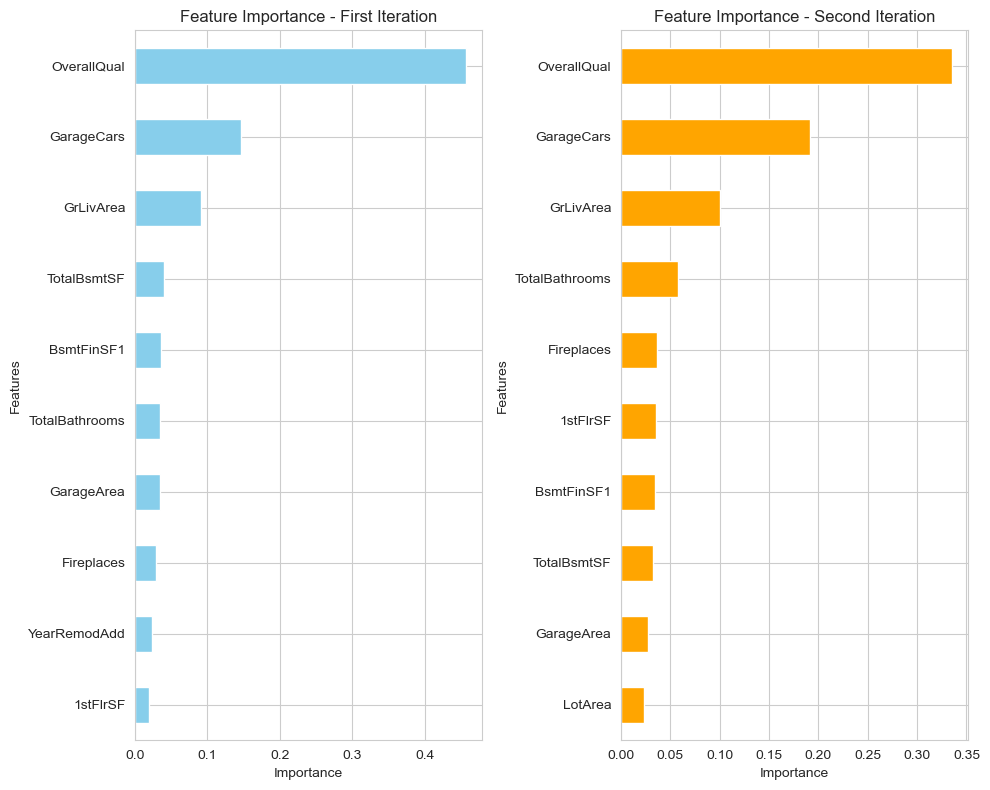

In [17]:
#Plot 1 - Actual vs Predicted
plt.figure(figsize=(18, 8))

# XGB 1st Iter
plt.subplot(1, 2, 1)
plt.scatter(ytest, y_test_pred_best_1, alpha=0.6, label='First Iteration')
plt.plot([ytest.min(), ytest.max()], [ytest.min(), ytest.max()], color='red', linestyle='--')
plt.title("First Iteration: Predicted vs. Actual")
plt.xlabel("Actual SalePrice")
plt.ylabel("Predicted SalePrice")
plt.legend()

# Xgb 2nd Iter
plt.subplot(1, 2, 2)
plt.scatter(ytest, y_test_pred_best_2, alpha=0.6, label='Second Iteration', color='orange')
plt.plot([ytest.min(), ytest.max()], [ytest.min(), ytest.max()], color='red', linestyle='--')
plt.title("Second Iteration: Predicted vs. Actual")
plt.xlabel("Actual SalePrice")
plt.ylabel("Predicted SalePrice")
plt.legend()

plt.tight_layout()
plt.show()

# plot 2 - residuals against predictions
plt.figure(figsize=(18, 8))

# 1st iter
plt.subplot(1, 2, 1)
residuals_first = ytest - y_test_pred_best_1
plt.scatter(y_test_pred_best_1, residuals_first, alpha=0.6, label='Residuals - First Iteration')
plt.axhline(0, color='red', linestyle='--')
plt.title("First Iteration Residuals")
plt.xlabel("Predicted SalePrice")
plt.ylabel("Residuals")
plt.legend()

# 2nd iter
plt.subplot(1, 2, 2)
residuals_second = ytest - y_test_pred_best_2
plt.scatter(y_test_pred_best_2, residuals_second, alpha=0.6, label='Residuals - Second Iteration', color='orange')
plt.axhline(0, color='red', linestyle='--')
plt.title("Second Iteration Residuals")
plt.xlabel("Predicted SalePrice")
plt.ylabel("Residuals")
plt.legend()

plt.tight_layout()
plt.show()

# plot 3 - residual histgram
plt.figure(figsize=(18, 8))

# 
plt.subplot(1, 2, 1)
sns.histplot(residuals_first, kde=True, bins=30, color='blue', alpha=0.6)
plt.axvline(0, color='red', linestyle='--')
plt.title("First Iteration Residual Distribution")
plt.xlabel("Residuals")
plt.ylabel("Frequency")

# Second Iteration Residual Distribution
plt.subplot(1, 2, 2)
sns.histplot(residuals_second, kde=True, bins=30, color='orange', alpha=0.6)
plt.axvline(0, color='red', linestyle='--')
plt.title("Second Iteration Residual Distribution")
plt.xlabel("Residuals")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

# Feature Importance Comparison (if features are the same between iterations)
plt.figure(figsize=(10, 8))

# Get Feature Importances
importances_first = best_xgb_1.feature_importances_
feature_importances_first = pd.Series(importances_first, index=Xtrain_reduced.columns).sort_values(ascending=False)

importances_second = best_xgb_2.feature_importances_
feature_importances_second = pd.Series(importances_second, index=Xtrain_reduced.columns).sort_values(ascending=False)

# Plot Comparison of Top 10 Features
plt.subplot(1, 2, 1)
feature_importances_first.head(10).plot(kind='barh', color='skyblue')
plt.title("Feature Importance - First Iteration")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.gca().invert_yaxis()

plt.subplot(1, 2, 2)
feature_importances_second.head(10).plot(kind='barh', color='orange')
plt.title("Feature Importance - Second Iteration")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()

#### Final Model - XGBoost Random Forest Model

In [18]:
# Save final model details
final_xgb_model_details = {
    "best_model": best_xgb_2,  # Final trained model
    "best_parameters": grid_search2.best_params_,  # Best hyperparameters found in GridSearchCV
    "best_cv_mse": -grid_search2.best_score_,  # Best CV MSE score
    "training_r2": r2_score(ytrain, y_train_pred_best_2),  # R² on training data
    "testing_r2": r2_score(ytest, y_test_pred_best_2),  # R² on testing data
    "training_mse": mean_squared_error(ytrain, y_train_pred_best_2),  # MSE on training data
    "testing_mse": mean_squared_error(ytest, y_test_pred_best_2),  # MSE on testing data
    "training_mae": mean_absolute_error(ytrain, y_train_pred_best_2),  # MAE on training data
    "testing_mae": mean_absolute_error(ytest, y_test_pred_best_2),  # MAE on testing data
    "feature_importances": pd.Series(
        best_xgb_2.feature_importances_, index=Xtrain_reduced.columns
    ).sort_values(ascending=False)  # Feature importances
}

# printing final model details
print("\nXGBoost Final Model Details:")
for key, value in final_xgb_model_details.items():
    if key == "feature_importances":
        print(f"{key}:\n{value.head(50)}")  # Print top 10 features for brevity
    else:
        print(f"{key}: {value}")


XGBoost Final Model Details:
best_model: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.65, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.02, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1200, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)
best_parameters: {'colsample_bytree': 0.65, 'learning_rate': 0.02, 'max_depth': 3, 'n_estimators': 1200, 'reg_alpha': 0.5, 'reg_lambda': 1, 'subsample': 0.65}
best_cv_mse: 333458145.0547773
training_r2: 0.98299187667

#### XGBoost Final Model Visualization of Model Performance:

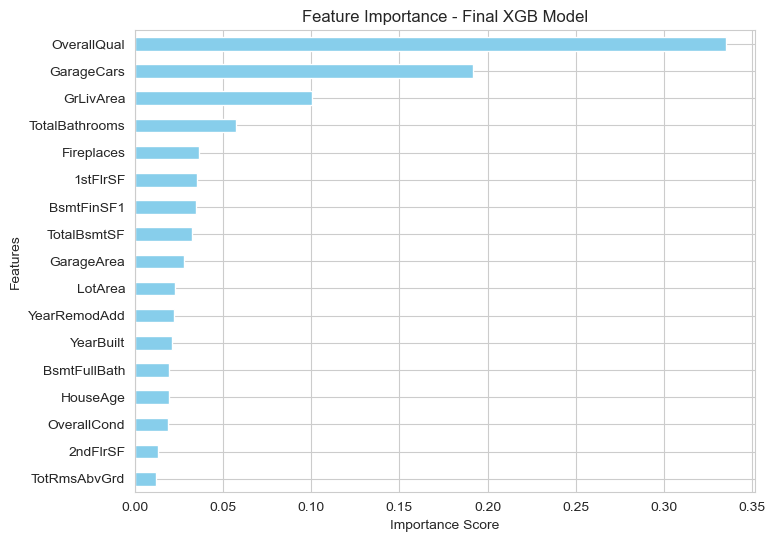

In [19]:
#Featue Importance Plot
plt.figure(figsize=(8,6))
final_xgb_model_details["feature_importances"].sort_values(ascending=False).plot(kind='barh', color='skyblue')
plt.title("Feature Importance - Final XGB Model")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.gca().invert_yaxis()
plt.show()

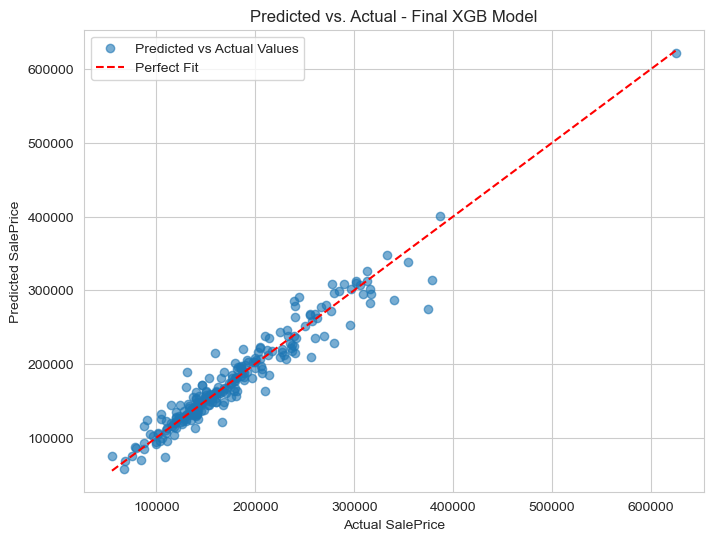

In [20]:
#Predicted vs Actual:
plt.figure(figsize=(8, 6))
plt.scatter(ytest, y_test_pred_best_2, alpha=0.6, label="Predicted vs Actual Values")
plt.plot([ytest.min(), ytest.max()], [ytest.min(), ytest.max()], 'r--', label="Perfect Fit")
plt.title("Predicted vs. Actual - Final XGB Model")
plt.xlabel("Actual SalePrice")
plt.ylabel("Predicted SalePrice")
plt.legend()
plt.show()

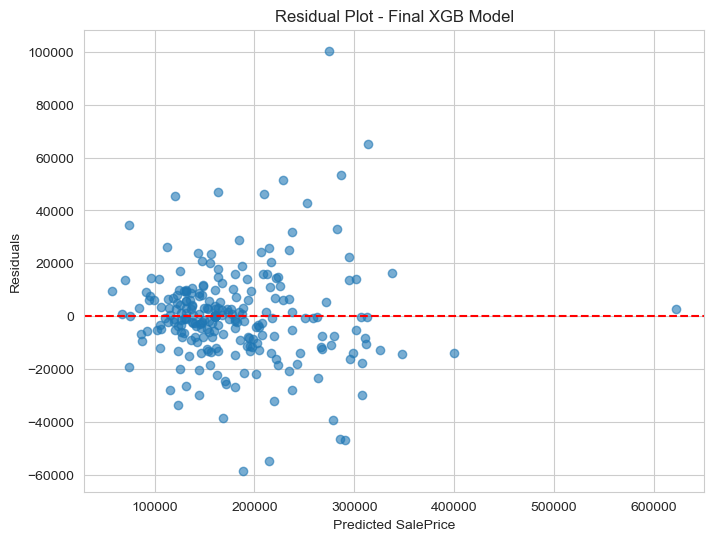

In [21]:
#residual plot against predicted values
res = ytest - y_test_pred_best_2
plt.figure(figsize=(8, 6))
plt.scatter(y_test_pred_best_2, res, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residual Plot - Final XGB Model")
plt.xlabel("Predicted SalePrice")
plt.ylabel("Residuals")
plt.show()

/Users/stephenkinsey/opt/anaconda3/envs/my_new_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


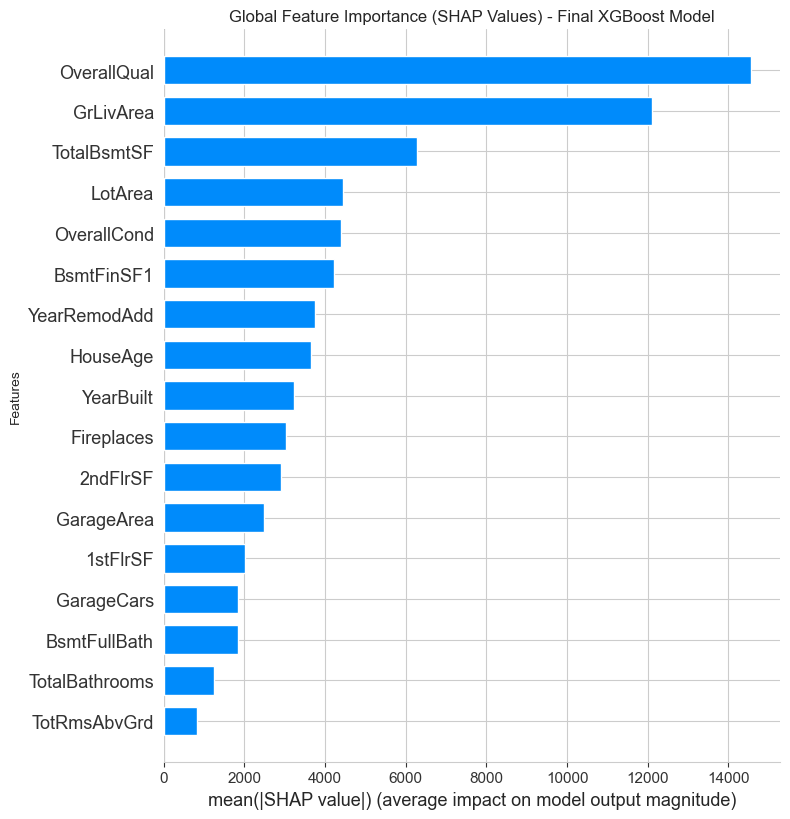

In [23]:
import shap

explainer=shap.Explainer(final_xgb_model_details["best_model"], Xtrain_reduced) #SHAP explainer initialization
shap_values = explainer(Xtest_reduced) #computing SHAP values for test set
plt.figure(figsize=(8, 6))
plt.title("Global Feature Importance (SHAP Values) - Final XGBoost Model")
plt.xlabel("Mean Absolute SHAPE Value (Impact on Model Output)")
plt.ylabel("Features")
shap.summary_plot(shap_values, Xtest_reduced, plot_type="bar")

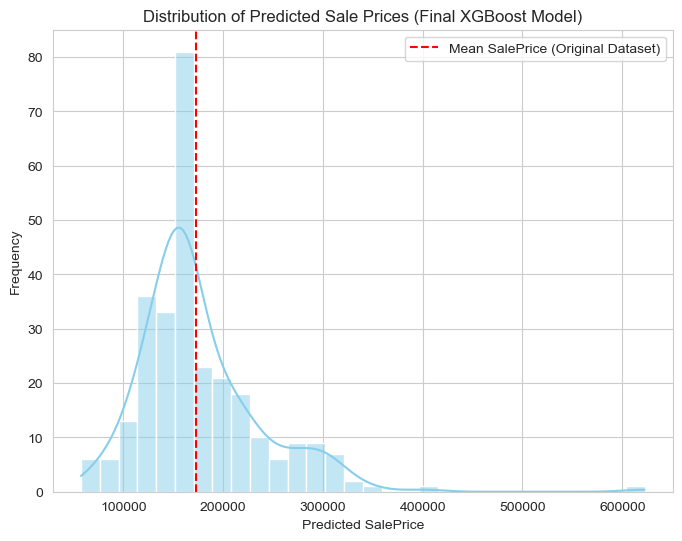

In [24]:
pred_vals = final_xgb_model_details["best_model"].predict(Xtest_reduced)
plt.figure(figsize=(8, 6))
sns.histplot(pred_vals, kde=True, bins=30, color='skyblue')
plt.title("Distribution of Predicted Sale Prices (Final XGBoost Model)")
plt.xlabel("Predicted SalePrice")
plt.ylabel("Frequency")
plt.axvline(df_cleaned['SalePrice'].mean(), color='red', linestyle='--', label='Mean SalePrice (Original Dataset)')
plt.legend()
plt.show()